<a href="https://colab.research.google.com/github/VintageGold/Text_Summarization/blob/main/notebooks/NER_Total_Count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NER Entity Notebook

* Telehealth NER analysis
* Indentify which documents each Entity belongs to
* Compare Pre-Covid and Post Covid Entity identification concerning Organizations and People

* <b> Classification - "Pre-Covid" and "Covid"<b>

# Conclusions
**Organizations**
<br>
From Pre-Covid to Covid organizations such as **APA**, **VA**, and **VHA** are key players and technology companies such as **Apple** and **Google** were overshadowed by government organization in their referenced amount.  A organization on the rise is **Zoom**, which is a video conferencing software that has had a rise throughout other industries during Covid.  

Google Hangout - Plans to change to [Google Chat](https://blog.google/products/workspace/latest-google-hangouts-and-upgrade-google-chat)
<br>
Skype - Is one of the oldest video conferencing tools and especially used in business.  As Skype Business is to be retired in 2021, many companies have switched to [Microsoft Teams](https://www.microsoft.com/en-us/fasttrack/skype-for-business-transition-to-teams).

**People**
<br>
Many new people are referenced so this is an active community.  **Shore** has persisted from Pre-Covid to Covid, so this individual may be an influential member of the community.  

**Products**
<br>
Many new products have been developed in the video conferencing space and also to facilitate telehealth through phone applications.

**Geographic Locations**
<br>
The sample consistently refers to **U.S.**. With new mentions of states **California**, **Arizona**, **Texas**, **Colorado**, and **Nebraska**.

Other countries mentioned are of **China**, and **Canada**.

# NER Model

In [54]:
#Spacy org
#!pip install spacy
#!python3 -m spacy download en_core_web_sm
#!python3 -m spacy download en_core_web_md
#!python3 -m spacy download en_core_web_lg
#!pip install spacy-transformers
#!python -m spacy download en_core_web_trf

In [ ]:
try:
    from google.colab import drive

    drive.mount('./drive/')

    %cd drive/My \ Drive/Text_Summarization

except:
    print("No Colab Environment")

Mounted at ./drive/
/content/drive/My  Drive/Text_Summarization


In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import yellowbrick

parameters = {'axes.labelsize': 25,
          'axes.titlesize': 35,
             'xtick.labelsize':20,
             "figure.figsize" : (20, 10)
             }


plt.rcParams.update(parameters)

df_overview = pd.read_csv("Data/processed/Telehealth.csv")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
import spacy
from spacy.lang.en import English
from datetime import date

corpus = df_overview["Content"]

nlp = spacy.load("en_core_web_trf")

docs = list(nlp.pipe(corpus,disable=["parser","textcat"]))
# https://spacy.io/api/language#from_disk
nlp.to_disk(f"Models/standard_spacy_transformer_{date.today()}")

In [7]:
ner_dict = dict() #used throughout analysis

ner_label_dict = dict() #contains dictionary of the NER Terms and meanings

for index,doc in enumerate(docs):

    for ent in doc.ents:
        
        if str(ent) not in ner_dict.keys():
            
            ner_label_dict[ent.label_] = spacy.explain(ent.label_)

            ner_dict[ent.text] = {"NER_Label":str(ent.label_),
                                  "Unique_Documents":{str(index)},"Full_Documents":list(str(index))
                                      }
            
        else:
            ner_dict[ent.text]["Unique_Documents"].add(index)
            ner_dict[ent.text]["Full_Documents"].append(index)
            

In [8]:
import json
    
with open("./references/ner_label_description.json","w") as f:
    json.dump(ner_label_dict, f, indent = 4)

In [ ]:
df_ner = pd.DataFrame.from_dict(ner_dict,orient="index")
df_ner.head(5)

In [ ]:
df_ner[["NER_Label"]].to_json("./references/ner_dictionary.json",orient="index",indent=4)

In [ ]:
#Load abrv dictionary to add long form.  This dictionary comes from the Wrangling notebook

with open("./references/abbreviation_table_processed.json", "r") as r:
    
    abrv_dict = json.load(r)


In [ ]:
#Apply abbrv to entities found
df_ner = df_ner.reset_index().rename(columns={"index":"Term"})
df_ner["Long_Form"] = df_ner["Term"].apply(lambda x: abrv_dict[x]["LongForm"] if x in abrv_dict.keys() else x)

df_ner.head(5)

In [ ]:
df_ner.to_json("./Data/processed/ner_analysis.json",orient="records",indent=4)

# Modify NER Classification

In [55]:
df_ner = pd.read_json("./Data/processed/ner_analysis.json",orient="records")
df_ner.head()

Term  ...                                          Long_Form
0                              Institute of Medicine  ...                              Institute of Medicine
1                                               2014  ...                                               2014
2                                          Tanielian  ...                                          Tanielian
3                                               2008  ...                                               2008
4  Substance Abuse and Mental Health Services Adm...  ...  Substance Abuse and Mental Health Services Adm...

[5 rows x 5 columns]

In [56]:
#Example Classification
df_ner[df_ner["Term"] == "Google"]

Term  ... Long_Form
2275  Google  ...    Google

[1 rows x 5 columns]

In [57]:
#Enable each term to be paired with the respective document to assign term to Classification
df_ner_exploded = df_ner.explode('Full_Documents')
df_ner_exploded.head()

Term NER_Label  ... Full_Documents              Long_Form
0  Institute of Medicine       ORG  ...              0  Institute of Medicine
0  Institute of Medicine       ORG  ...              0  Institute of Medicine
0  Institute of Medicine       ORG  ...             10  Institute of Medicine
0  Institute of Medicine       ORG  ...             10  Institute of Medicine
0  Institute of Medicine       ORG  ...             42  Institute of Medicine

[5 rows x 5 columns]

In [58]:
#Merge Document to main file to determine covid and pre-covid entities
entity_by_document_overview = df_ner_exploded.merge(df_overview,left_on="Full_Documents",right_on=df_overview.index)

In [59]:
#Classification is the last column
entity_by_document_overview.head()

Term  ... Classification
0  Institute of Medicine  ...          Covid
1                   2014  ...          Covid
2                   2014  ...          Covid
3                   2014  ...          Covid
4                   2014  ...          Covid

[5 rows x 22 columns]

In [60]:
entity_by_document_overview["NER_Label"].unique()

array(['ORG', 'DATE', 'PERSON', 'CARDINAL', 'ORDINAL', 'LOC', 'GPE',
       'WORK_OF_ART', 'EVENT', 'LAW', 'NORP', 'PRODUCT', 'PERCENT',
       'TIME', 'MONEY', 'LANGUAGE', 'FAC', 'QUANTITY'], dtype=object)

# Plot Overall Entities Labels

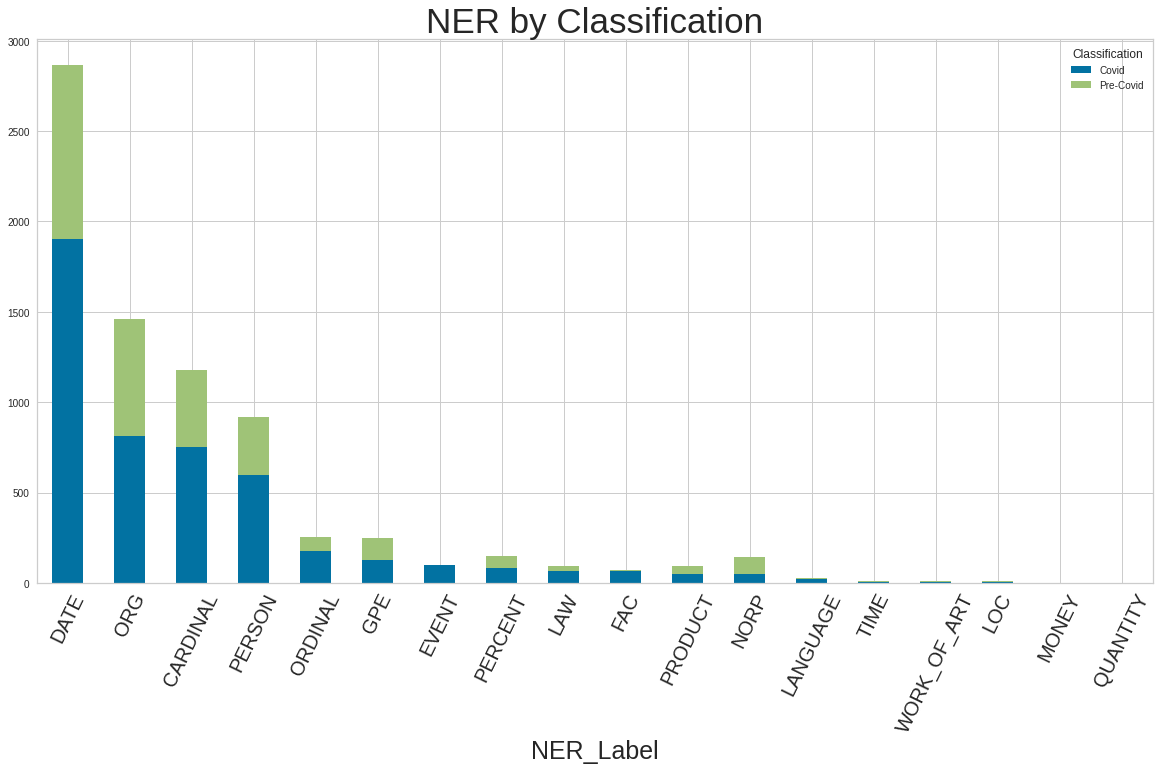

In [61]:
ner_overview_plot = (entity_by_document_overview.groupby(['Classification', 'NER_Label']).size().reset_index()
           .pivot(columns='Classification', index='NER_Label', values=0)
           .sort_values(by="Covid",ascending=False))

ner_overview_plot.plot(kind='bar', stacked=True,title="NER by Classification")
_ = plt.xticks(rotation=64)

# Top 10 of ORG and Person since they have the highest identifications

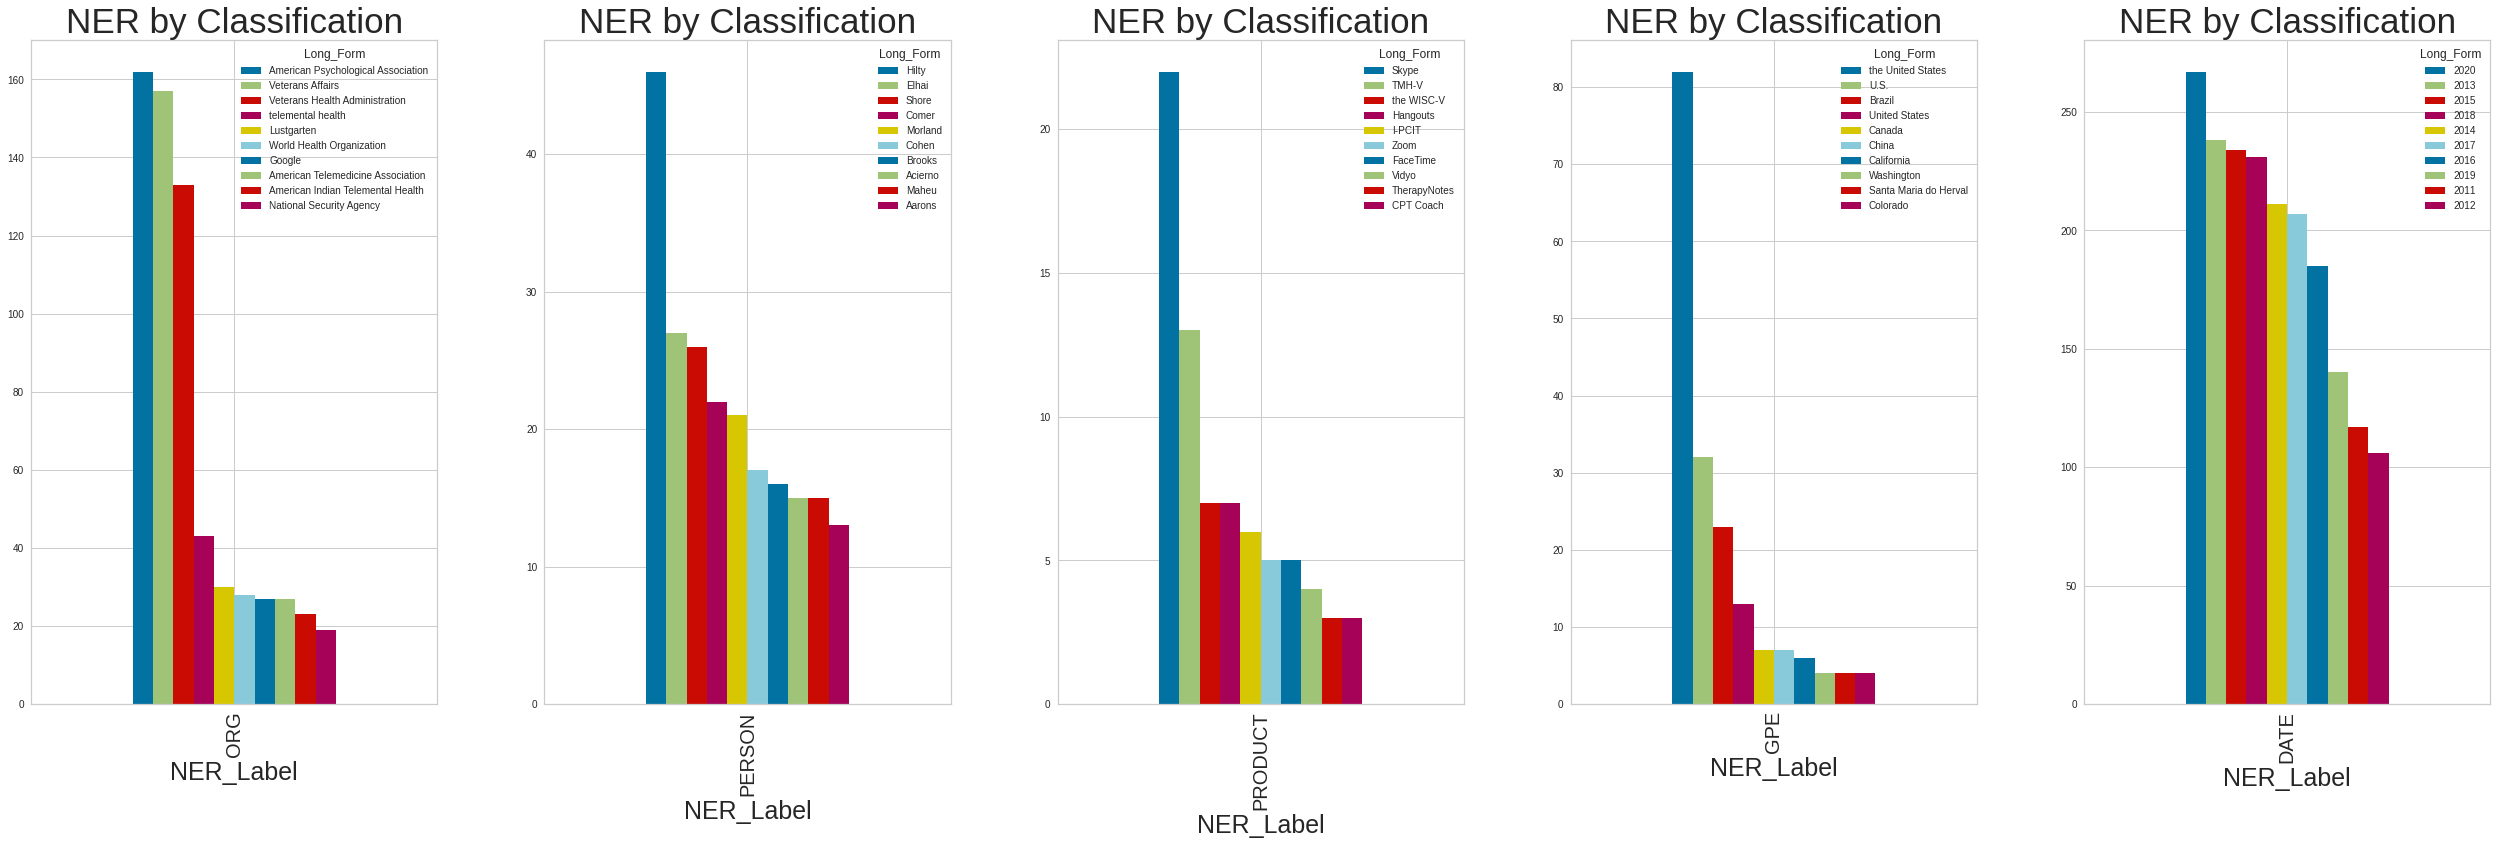

In [62]:
top = 10

visualize_cols = ["ORG","PERSON","PRODUCT","GPE","DATE"]

fig, ax = plt.subplots(1,len(visualize_cols),figsize=(35,10))
fig.tight_layout(h_pad=2,w_pad=6)

for index,col in enumerate(visualize_cols):

    dataset = entity_by_document_overview.query(f'NER_Label == "{col}"')

    ner_overview_plot = (dataset.groupby(['Long_Form', 'NER_Label']).size().reset_index()
                         
                .pivot(columns='NER_Label', index='Long_Form', values=0)
                         
                 .sort_values(by=col,ascending=False)
                 .head(top)
                         
                .T
                )
                

    ner_overview_plot.plot(kind='bar',title="NER by Classification",ax=ax[index])

# Filter datasets for comparison

In [63]:
entity_by_document_overview.head()

Term  ... Classification
0  Institute of Medicine  ...          Covid
1                   2014  ...          Covid
2                   2014  ...          Covid
3                   2014  ...          Covid
4                   2014  ...          Covid

[5 rows x 22 columns]

In [67]:
#Create precovid dataset
pre_covid = (entity_by_document_overview
             .query('Classification == "Pre-Covid"'))


pre_covid_plot = (pre_covid[["NER_Label","Long_Form","Term","Full_Documents"]]
                  .groupby(["NER_Label","Long_Form"])
                  .count()
                  .sort_values(by="Full_Documents",ascending=False)
                  .rename(columns={"Full_Documents":"Pre-Covid"})
                  .reset_index()
                 
                 
                 )

pre_covid_plot["Classification"] = "Pre-Covid"
pre_covid_plot.head()

NER_Label                           Long_Form  Term  Pre-Covid Classification
0      DATE                                2015   121        121      Pre-Covid
1      DATE                                2013   104        104      Pre-Covid
2      DATE                                2014    98         98      Pre-Covid
3  CARDINAL                                 one    72         72      Pre-Covid
4       ORG  American Psychological Association    66         66      Pre-Covid

In [68]:
#Create covid dataset

covid = (entity_by_document_overview
              .query('Classification == "Covid"'))


covid_plot = (post_covid[["NER_Label","Long_Form","Term","Full_Documents"]]
                  .groupby(["NER_Label","Long_Form"])
                  .count()
                  .sort_values(by="Full_Documents",ascending=False)
                  .rename(columns={"Full_Documents":"Covid"})
                  .reset_index()
                 
                 
                 )


covid_plot["Classification"] = "Covid"
covid_plot.head()

NER_Label Long_Form  Term  Covid Classification
0      DATE      2020   267    267          Covid
1      DATE      2018   198    198          Covid
2      DATE      2017   166    166          Covid
3      DATE      2019   138    138          Covid
4      DATE      2013   134    134          Covid

In [69]:
plot_by_time = pd.concat([covid_plot,pre_covid_plot]).fillna(0)

# NER ORG Comparison

In [70]:
#Creates the plots to compare the Classifications
def plot_compare(data,ner_kind,top=10):

    fig, ax = plt.subplots(2,1,figsize=(30,15),sharex=True)
    fig.tight_layout(h_pad=4,w_pad=10)

    plot_by_time = data.query(f'NER_Label == "{ner_kind}"')
    
    classifications = ["Pre-Covid","Covid"]

    for index,classification in enumerate(classifications):

        combine_plot = (plot_by_time.groupby("Long_Form").sum() #Need to since terms can occur in both classifications

                        .sort_values(by=classification,ascending=False)

                        .rename(columns={"Term":"Total_Count"})

                        .drop(columns="Total_Count")

                        .head(top)

                        )

        (combine_plot.plot(kind="barh",stacked=True,title=f"{classification} - NER_Label - {ner_kind}",ax=ax[index]))
        
        ax[index].invert_yaxis()

# Take aways
<b> Same <b>
* APA, VA, and VHA have been used consistently pre-covid and covid
* Obviously telehealth will be popular in pre-covid and covid
    
<b> Noticeable Movements <b>
    
<b> Rise <b>
* Medicare - Maybe questions whether it is covered under health insurance
* World Health Organization - Global Pandemic
* CDC
* Development of Joint Task Force for Telepsychology Guidelines
* Psychology Training Clinics
    
<b> Fall <b>
* Lustgarten
* American Indian Tele Health
* Google
* National Security Agency
* Internet-guided self help
* Microsoft

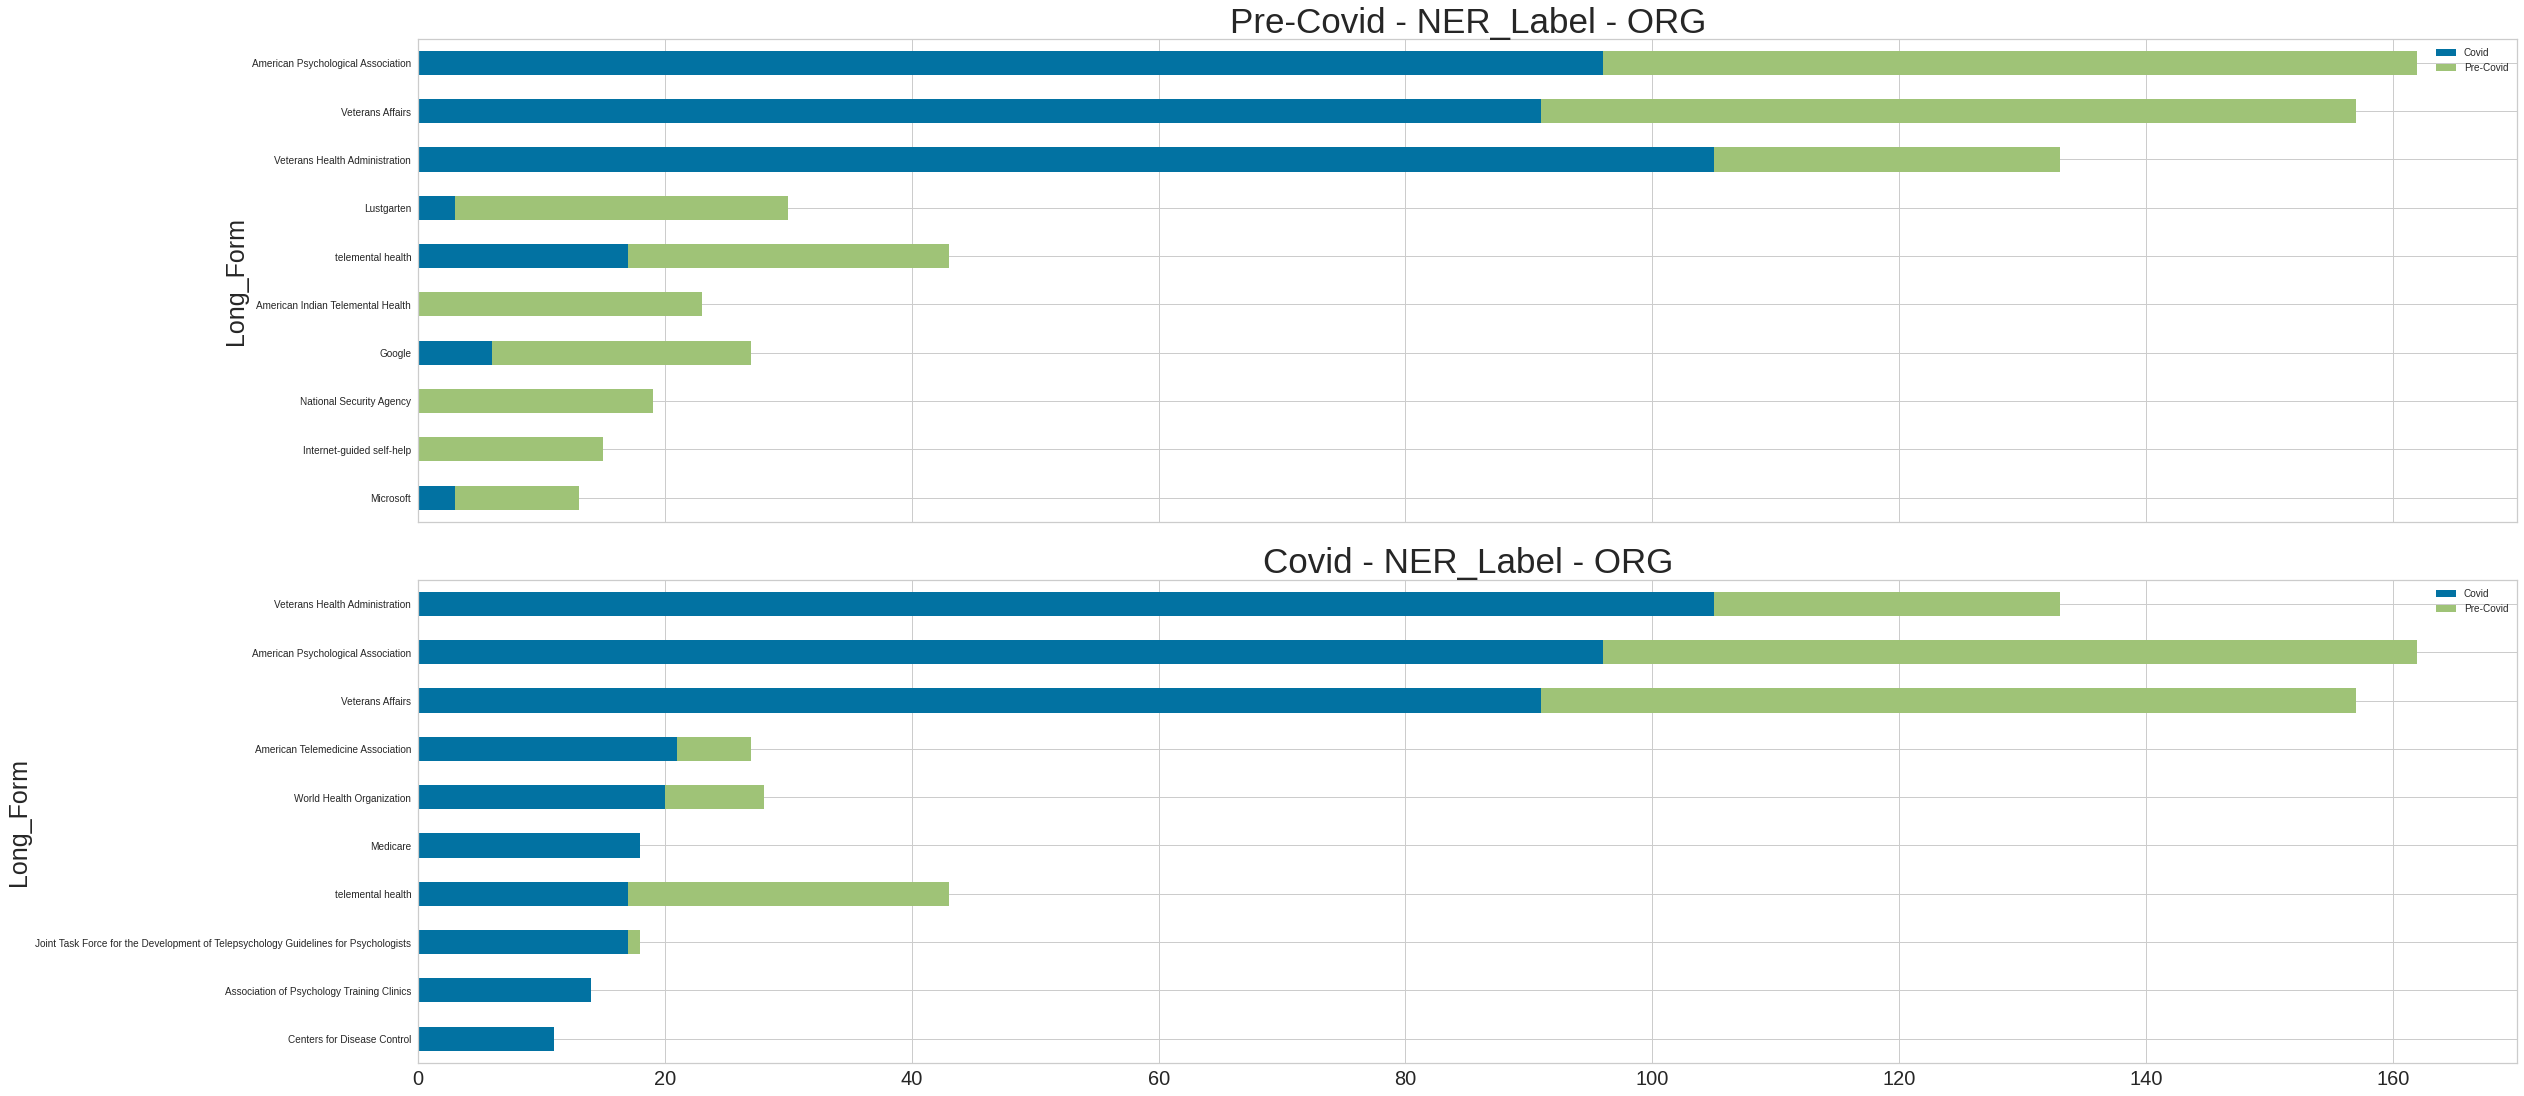

In [71]:
plot_compare(plot_by_time,"ORG")

# Take aways - Possible emerging leaders in the field
<b> Same <b>
* Shore - Possible influential member of the community
    
<b> Noticeable Movements <b>
    
<b> Rise <b>
* Hilty - Could be a new influential member of the community
* Large rise of new people

    
<b> Fall <b> 

<b> Largest Fall <b>
* Borgueta
* Kaufmann
* Peese

<b> Other Falls <b>
* Elhai
* Wade
* Mohr
* Osenbach


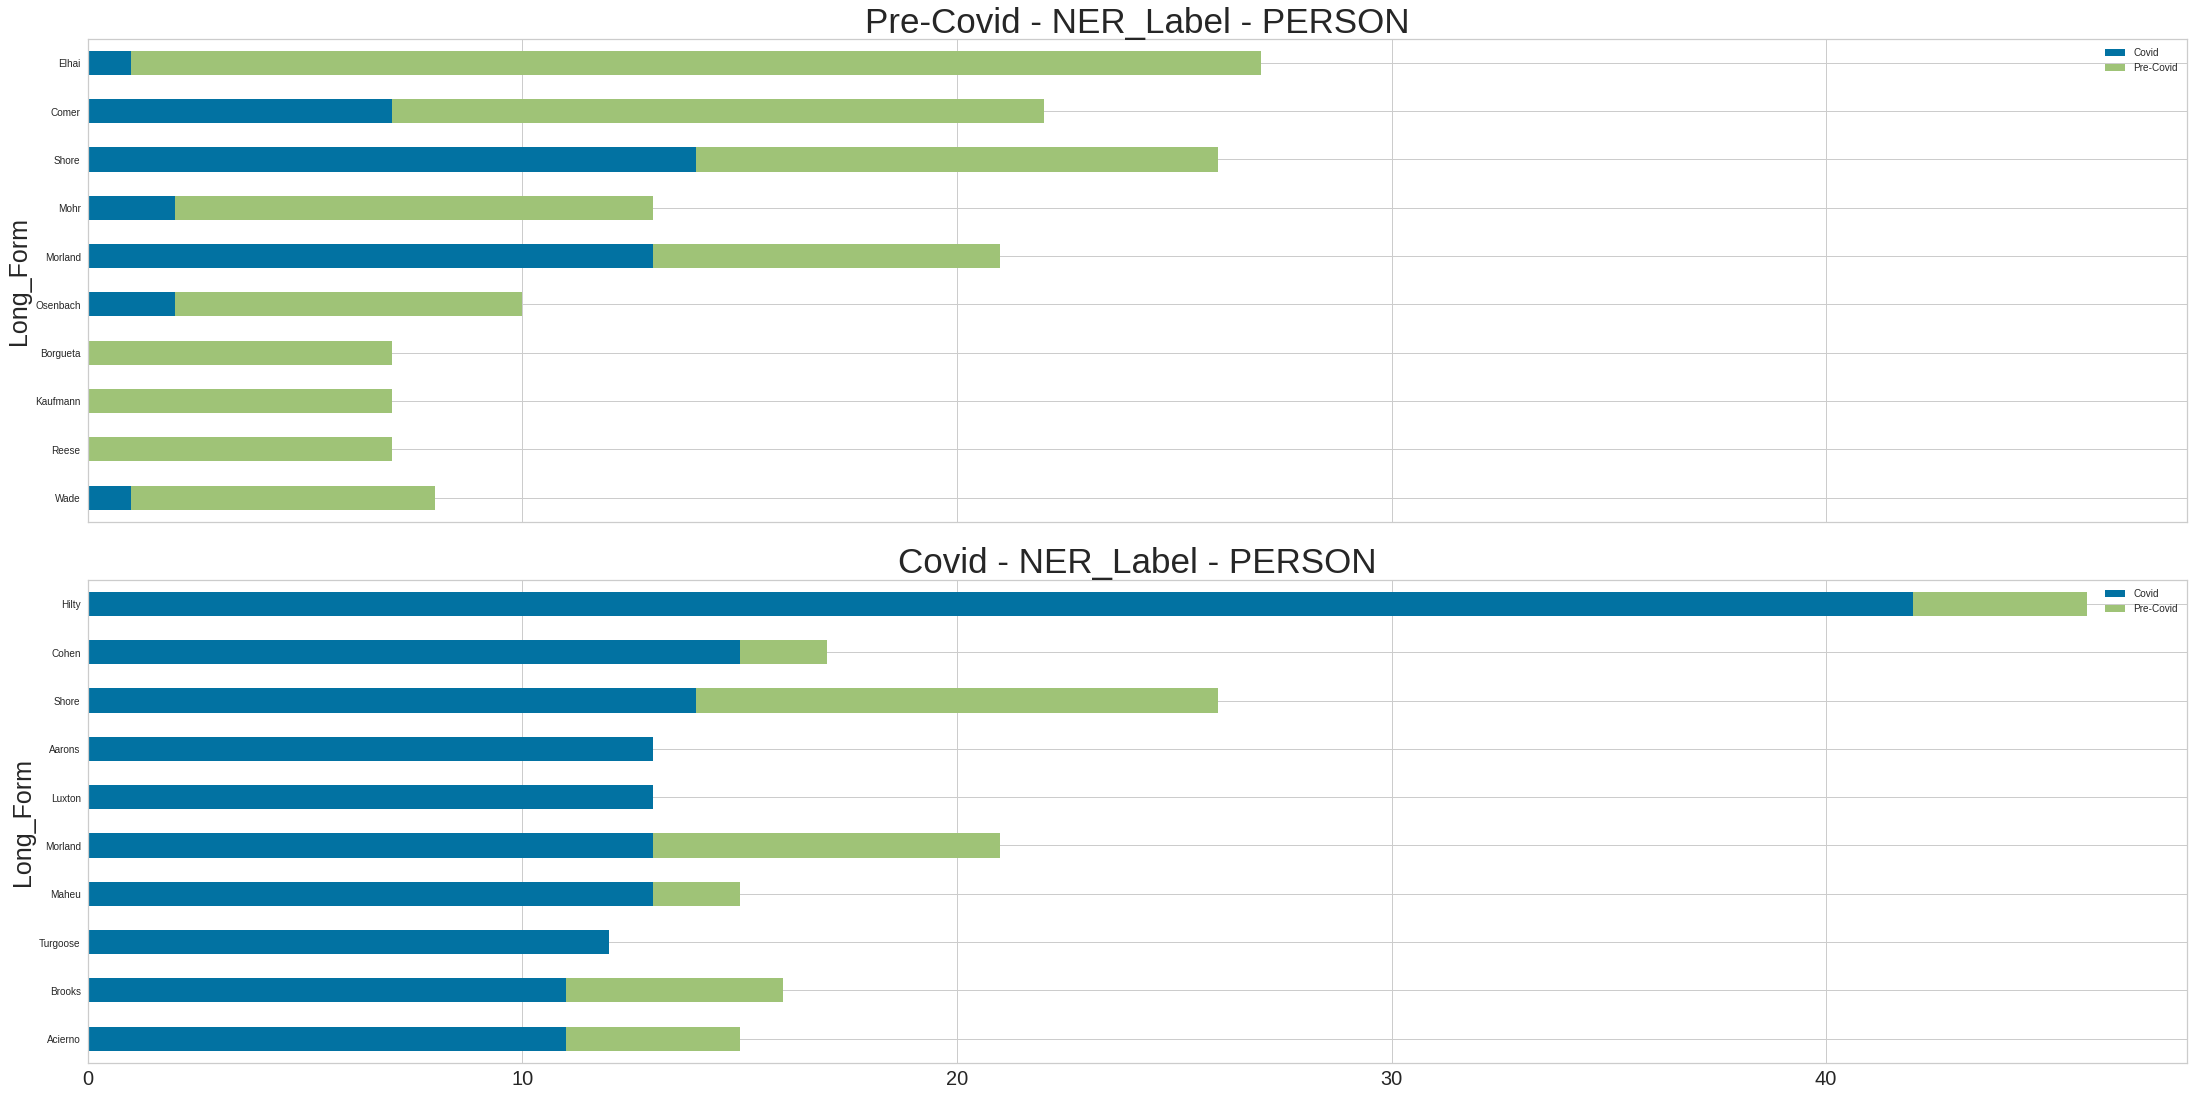

In [72]:
plot_compare(plot_by_time,"PERSON")




# Take aways - Possible emerging leaders in the field
<b> Same <b>
* Skype mentioned in pre-covid and covid, but in covid classified documents Zoom has the same number of mentions as Skype
    
<b> Noticeable Movements <b>
    
<b> Rise <b>

* [Zoom](https://zoom.us/) - Video Conferencing Company

* [WISC-V](https://www.pearsonassessments.com/store/usassessments/en/Store/Professional-Assessments/Cognition-%26-Neuro/Gifted-%26-Talented/Wechsler-Intelligence-Scale-for-Children-%7C-Fifth-Edition-/p/100000771.html) - Wechsler Intelligence Scale for Children (PEARSON Product)

* [TMH-V](https://www.liebertpub.com/doi/full/10.1089/tmj.2020.0233) - Telemental Health over video conferencing

* [Vidyo](https://www.vidyo.com/) - Video Conferencing Platform

* [Therapy Notes](https://www.therapynotes.com/) - Software for taking therapy notes

* [CPT Coach](https://mobile.va.gov/app/cpt-coach) - CPT Coach is for those with posttraumatic stress disorder (PTSD) who are participating in Cognitive Processing Therapy (CPT) with a professional mental healthcare provider.


* [TF-CBT](https://www.tfcbt.org/) - Trauma-Focused Cognitive Behavioral Therapy (TF-CBT) is an evidence-based treatment for children and adolescents impacted by trauma and their parents or caregivers. 

* [COVID Coach](https://mobile.va.gov/app/covid-coach) - Support self-care and overall mental health during the coronavirus (COVID-19) pandemic.

    
<b> Fall <b> 

* [DX80](https://www.cisco.com/c/en/us/products/collaboration-endpoints/dx80/index.html) - HD video conferencing and digital whiteboarding

* Google Hangout - Plans to change to [Google Chat](https://blog.google/products/workspace/latest-google-hangouts-and-upgrade-google-chat)
<br>
* Skype - Is one of the oldest video conferencing tools and especially used in business.  As Skype Business is to be retired in 2021, many companies have switched to [Microsoft Teams](https://www.microsoft.com/en-us/fasttrack/skype-for-business-transition-to-teams).

* [Facetime](https://apps.apple.com/us/app/facetime/id1110145091) - Make audio and video calls from your iPhone, iPad, and iPod touch to other iOS devices or even a Mac.

* I-PCIT - Assumption is "Interpersonal person centered therapy" not a widely used term anymore



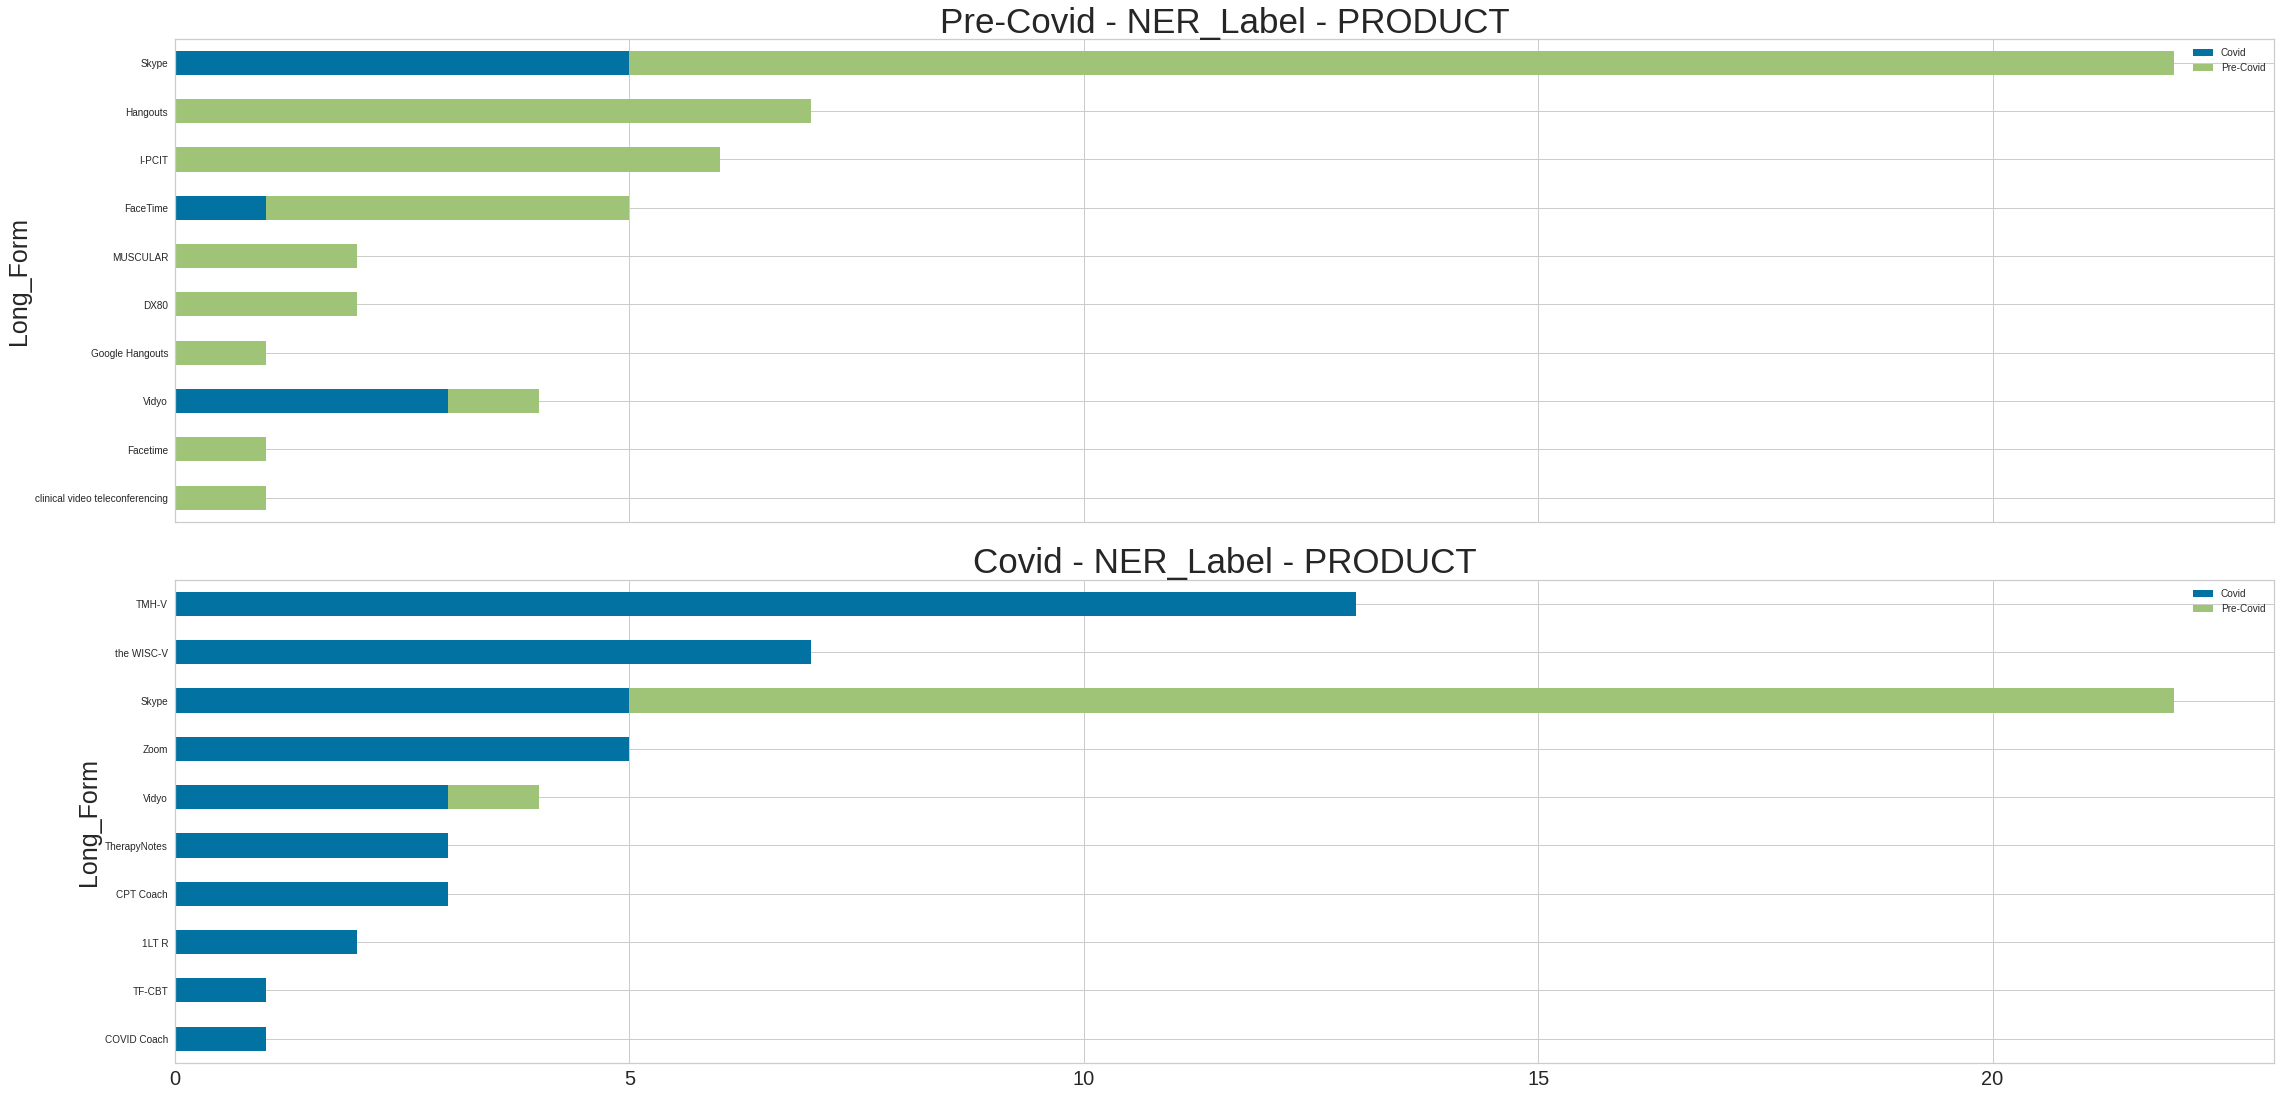

In [73]:
plot_compare(plot_by_time,"PRODUCT")

# Take aways - Possible emerging leaders in the field
<b> Same <b>
* United States
    
<b> Noticeable Movements <b>
* Everything else has changed from Pre-Covid to Covid





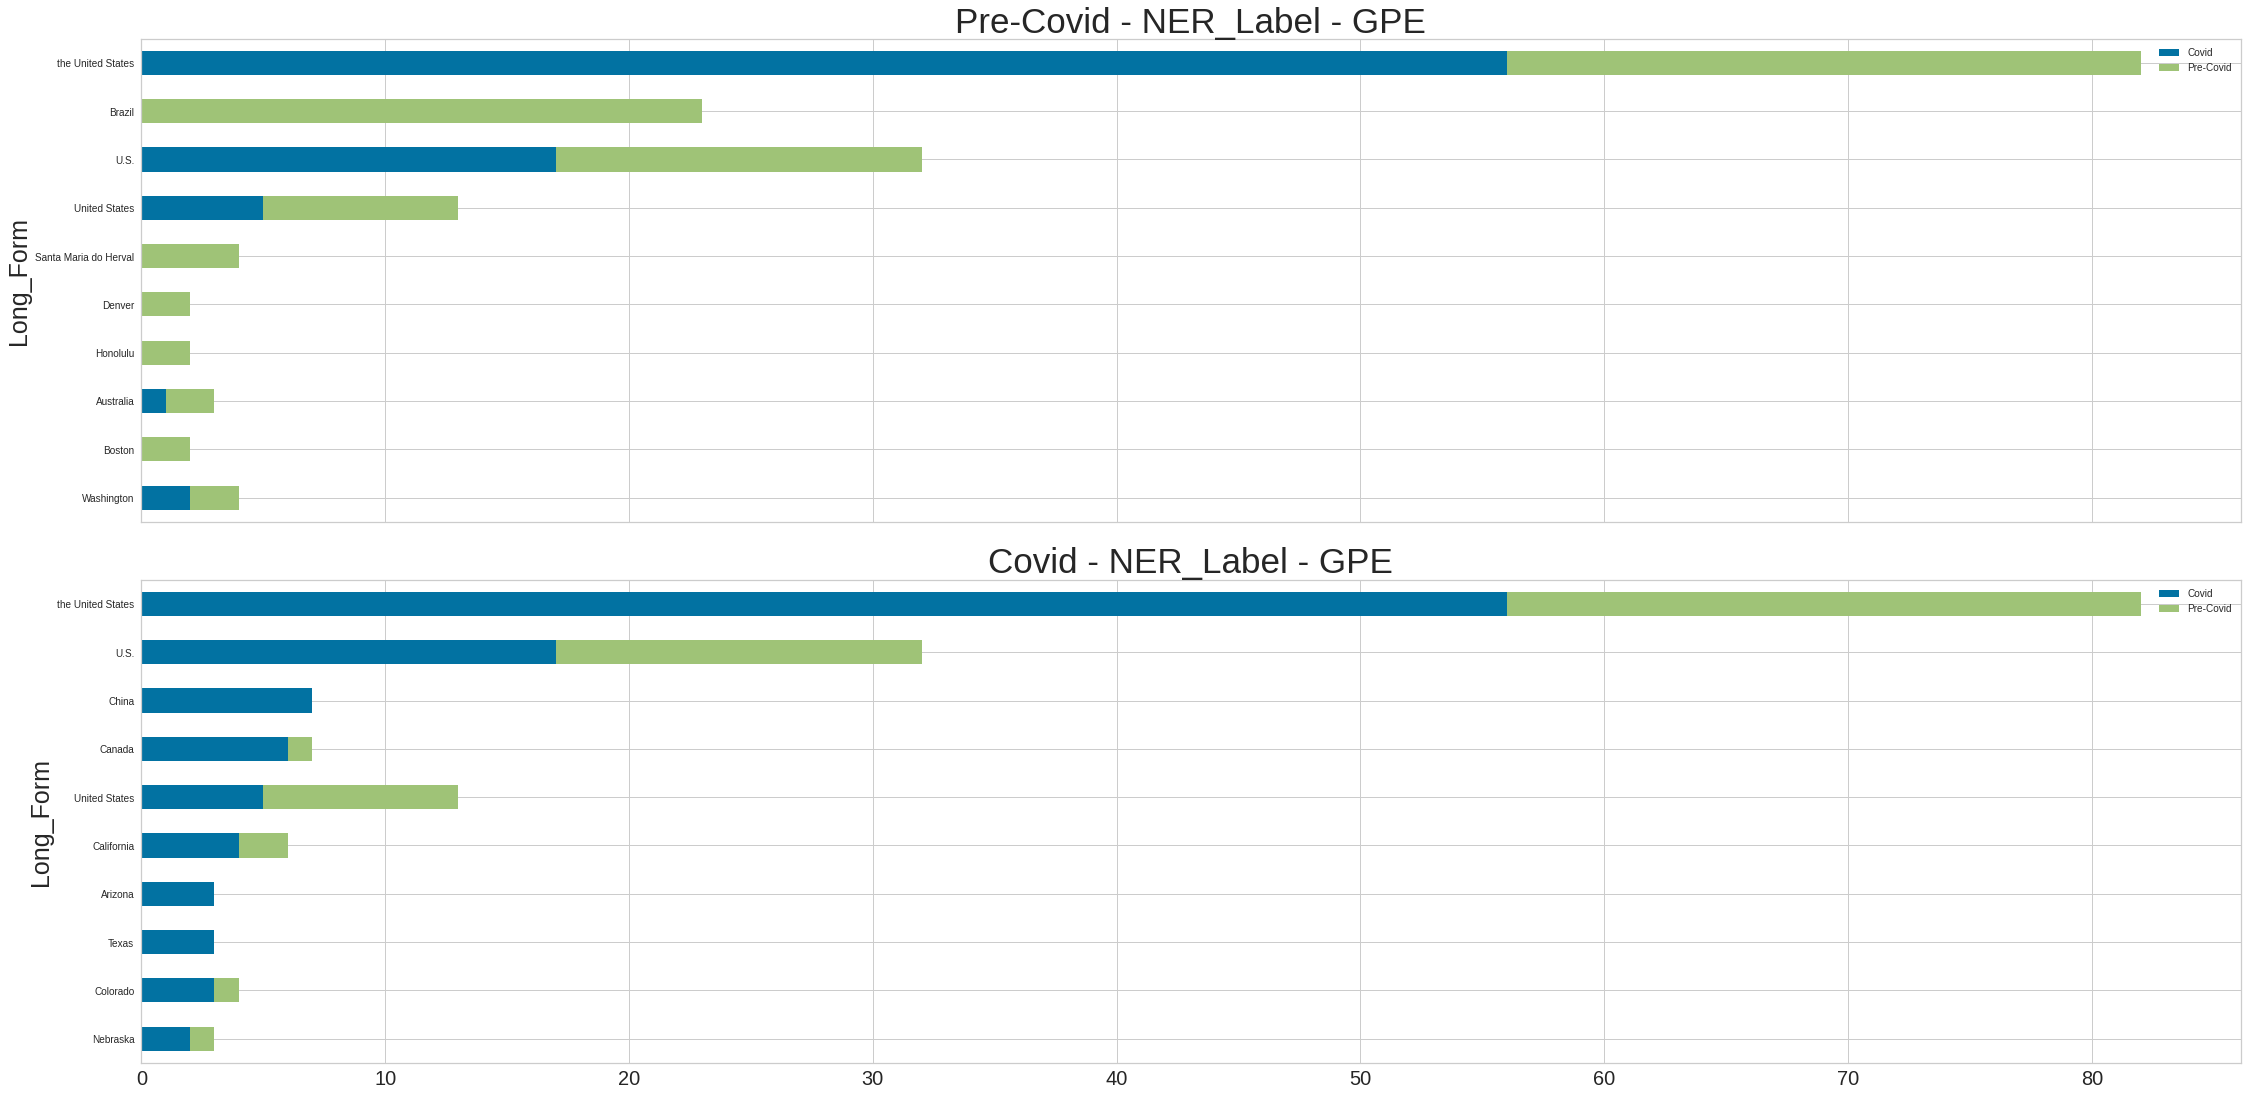

In [74]:
plot_compare(plot_by_time,"GPE")